# <center> **Разбор кейса ML-инженера**

## **Обучим и протестируем модель**

In [5]:
#!pip install lightfm

In [6]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse # разреженные матрицы
from lightfm import LightFM # модель
from lightfm.cross_validation import random_train_test_split # разделение выборки кросвалидация
from lightfm.evaluation import precision_at_k, recall_at_k # метрики
import pickle # для сохранения результатов

In [7]:
# прочитаем данные
ratings = pd.read_csv('data/ratings.csv') 
books = pd.read_csv('data/books.csv') 
tags = pd.read_csv('data/tags_cleaned.csv') # названия тегов
book_tags = pd.read_csv('data/book_tags.csv') # соответствие тегов книгам

Теги взяты из сервиса *Goodreads*

In [8]:
book_tags.head(2)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174


In [9]:
books.head(2)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


### **ПРЕДОБРАБОТКА ДАННЫХ**

В датафреймах *book_tags* и *books* есть два идентификатора: `goodreads_book_id` — от сервиса *Goodreads* и `book_id`, который привязан к нашей таблице. Создадим словарь, с помощью которого сможем находить `book_id` книги по `goodreads_book_id`.

In [10]:
mapper = dict(zip(books.goodreads_book_id,books.book_id))

Теперь применим этот словарь, чтобы добавить *id* книги в датафрейм *book_tags*.

In [11]:
# оставим только те теги, у которых есть определение
book_tags = book_tags[book_tags.tag_id.isin(tags.tag_id)]
# добавим ид книги с помощью словаря, созданного ранее
book_tags['id'] = book_tags.goodreads_book_id.apply(lambda x: mapper[x])

In [12]:
tags

,tag_id,tag_name
0,509,19th-century
1,923,20th-century
2,941,21st-century
3,1499,abuse
4,1540,action
...,...,...
329,33114,young-adult
330,33121,young-adult-fantasy
331,33124,young-adult-fiction
332,33165,youth


In [13]:
book_tags.head()

,goodreads_book_id,tag_id,count,id
1,1,11305,37174,27
4,1,33114,12716,27
5,1,11743,9954,27
6,1,14017,7169,27
10,1,27199,3857,27


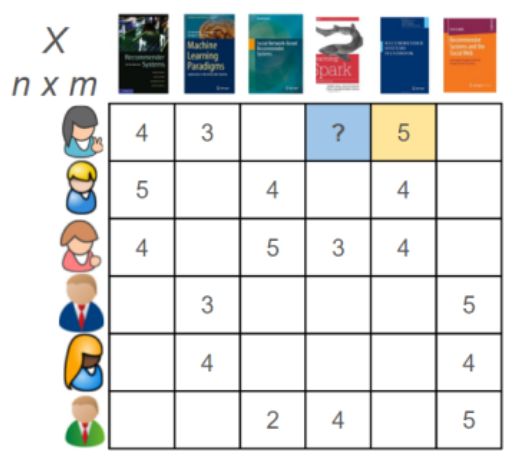 

> Как вы уже знаете, для работы с моделями в библиотеке *LightFM* необходимо создать разрежённые матрицы. Для их построения мы будем использовать библиотеку *scipy*.

Разрежённые матрицы в модуле *scipy* могут иметь несколько форматов:

* **Список координат (Coordinate List, COO)** — самый простой способ составления разрежённой матрицы. Согласно этому представлению, компьютер хранит массивы строк и столбцов ненулевых значений, а также сами ненулевые значения. В *COO* данные представлены в виде `строка`, `столбец`, `значение`.

* **Cжатое хранение строк (Compressed Sparse Row, CSR)** подразумевает подсчёт кумулятивной суммы количества элементов в строке вместо индексов строк.

* **Сжатое хранение столбцов (Compressed Sparse Column, CSС)** подразумевает подсчёт кумулятивной суммы количества элементов в столбце.

> **Примечание**. Подробнее узнать о различиях этих форматов можно [здесь](https://python-school.ru/blog/sparse-matrix-scipy/).

Мы будем хранить данные в самом простом формате — *COO* (координатный формат представления данных). То есть вместо хранения всех значений, которые включают и нулевые, мы будем хранить только ненулевые значения и их индексы.

#### Пример для понимания разреженных матриц.

_________________

In [14]:
import numpy as np

# имеем некоторую матрицу
np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 2, 1, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 3, 0],
])

# создание разреженной матрицы из общей матрицы сочетаний
# sparse.coo_matrix(array)

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 2, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 3, 0]])

In [15]:
# создание разреженной матрицы с использованием извесных координат (наш случай)
rows = [0, 1, 1, 1, 3 ,3]
cols = [1, 2, 3, 6, 3, 5]
data = [1, 2, 1, 1, 1, 3]

coo = sparse.coo_matrix((data, (rows, cols)))

In [16]:
coo

<4x7 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in COOrdinate format>

Разреженная матрица представляет собой список координат и значений, находящихся по этим координатам.

In [17]:
print(coo)

  (0, 1)	1
  (1, 2)	2
  (1, 3)	1
  (1, 6)	1
  (3, 3)	1
  (3, 5)	3


_____________

#### Создание разреженной матрицы оценок книг пользователями

In [18]:
book_tags

,goodreads_book_id,tag_id,count,id
1,1,11305,37174,27
4,1,33114,12716,27
5,1,11743,9954,27
6,1,14017,7169,27
10,1,27199,3857,27
...,...,...,...,...
999877,33288638,9886,10,8892
999879,33288638,3358,10,8892
999880,33288638,1679,10,8892
999889,33288638,1659,9,8892


In [19]:
# создадим координатную разреженную матрицу оценок книг пользователями
ratings_coo = sparse.coo_matrix((ratings.rating,(ratings.user_id, ratings.book_id)))
# создадим координатную разреженную матрицу соответствия тегов книгам
feature_ratings  = sparse.coo_matrix(([1]*len(book_tags), (book_tags.id, book_tags.tag_id)))

In [20]:
ratings_coo

<53425x10001 sparse matrix of type '<class 'numpy.int64'>'
	with 5976479 stored elements in COOrdinate format>

### **ПОСТРОЕНИЕ МОДЕЛИ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ**

Объявим вспомогательные константы для обучения модели:

In [21]:
#число потоков нашего процессора. Ставим 1, так как lightfm на macos ставится без OpenMP
NUM_THREADS = 10

#число параметров вектора 
NUM_COMPONENTS = 60

#число эпох обучения
NUM_EPOCHS = 10 

#зерно датчика случайных чисел
RANDOM_STATE = 42

На этапе создания модели мы используем библиотеку LightFM, чтобы сделать матричное разложение (ALS) наших рейтингов книг и получить два набора векторов. 

In [22]:
#Разбиваем наш датасет на обучающую и тестовую выборки
train, test = random_train_test_split(ratings_coo, test_percentage=0.2, random_state=RANDOM_STATE)

#Создаём модель
model = LightFM(
    learning_rate=0.05, #темп (скорость) обучения
    loss='warp', #loss-функция
    no_components=NUM_COMPONENTS,#размерность вектора признаков
    random_state=RANDOM_STATE #генератор случайных чисел
)

#Обучаем модель
model = model.fit(
    train, #обучающая выборка
    epochs=NUM_EPOCHS, #количество эпох обучения
    num_threads=NUM_THREADS, #количество потоков процессора
    item_features=feature_ratings #признаки товаров (рейтинги книг)
)

Синтаксис очень похож на привычный *scikit-learn*: первый набор отвечает векторному представлению пользователя, а второй соответствует векторному представлению книг. Эти векторы мы будем использовать при составлении эмбедингов.

### **ТЕСТИРОВАНИЕ МОДЕЛИ**

Перед тем как переходить к использованию модели, давайте посмотрим, насколько хорошо она обучилась. Будем использовать наиболее популярные (в рекомендательных системах) метрики качества — **precision at k** и **recall at k**. Давайте вспомним назначение этих метрик:

> **precision at k (precision@k)** — это отношение количества релевантных предложений в списке рекомендаций к общему количеству предложений, при этом количество предложений равно k.

**Что это значит?** Допустим, мы делаем 10 рекомендаций и наша метрика *precision at 10* равняется *80 %*. Это значит, что *80 %* наших рекомендаций релевантны для пользователя.

> **recall at k (recall@k)** — это отношение количества релевантных предложений в списке рекомендаций к количеству релевантных предложений в принципе.

**Что это значит?** Допустим, мы делаем 10 рекомендаций и наша метрика *recall at 10* равняется *40 %*. Это значит, что если взять все релевантные предложения, то *40 %* из них появятся в списке наших рекомендаций.

В идеале мы должны стремиться к *precision* и *recall* = 1.0. К сожалению, такое практически невозможно, как почти невозможно получить 100 % точность в задачах классификации.

> **Важно**. Плохой *precision* или плохой *recall* не означает, что вы получите плохие эмбеддинги. Это следствие того, что модель тренируется через алгоритм *ALS*, который использует другую метрику качества при обучении.

Измерим качество нашей модели, воспользовавшись встроенными в *LightFM* функциями `precision_at_k()` и `recall_at_k()`:

In [23]:
#Тестируем нашу модель
precision_score = precision_at_k(
    model, #модель
    test, #тестовая выборка
    num_threads=NUM_THREADS, #количество потоков процессора
    k=10, #количество предложений
    item_features=feature_ratings #признаки товаров
).mean() #усредняем результаты
 
recall_score = recall_at_k(
    model, #модель
    test, #тестовая выборка
    num_threads=NUM_THREADS, #количество потоков процессора
    k=10, #количество предложений
    item_features=feature_ratings #признаки товаров
).mean() #усредняем результаты

print(recall_score, precision_score)

0.040134537466226715 0.08688931


> Результаты получаются неидеальными, однако для тестирования функциональности такого *baseline* будет достаточно. Вы можете поэкспериментировать с параметрами, чтобы добиться других результатов. Однако основная цель нашей работы иная — создать прототип модели, поэтому мы продолжим двигаться в этом направлении, и следующим этапом будет добавление эмбеддингов.

Если вы обучали модель самостоятельно, то рекомендуем сохранить её в формате *pickle*, чтобы впоследствии при перезапуске ноутбука вам не пришлось выполнять обучения заново:

In [24]:
# with open('model.pkl', 'wb') as file:
#     pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

## **Добавим эмбеддинги к модели и посмотрим, что получилось**

**Примечание.** Если вы пропустили этап обучения и тестирования модели, не забудьте десериализовать модель из файла:

In [ ]:
# with open('model.pkl', 'rb') as file:
#     model = pickle.load(file)

Для начала давайте воспользуемся обученной ранее моделью, чтобы получить новые векторные представления книг, которые называются **эмбеддингами (embeddings)**. Проще говоря, мы хотим на основе матричного разложения, полученного с помощью нашей модели, представить каждую книгу в виде вектора в некотором пространстве размерностью `NUM_COMPONENTS`.

В нашем случае одной книге соответствует вектор размерности `NUM_COMPONENTS = 60` (мы задавали это значение ранее).

In [25]:
# Достаём эбмеддинги
item_biases, item_embeddings = model.get_item_representations(features=feature_ratings)

print(item_biases.shape, item_embeddings.shape)

(10001,) (10001, 60)


**МЫ ПОЛУЧИЛИ ЭМБЕДДИНГИ — ЧТО ДЕЛАТЬ С НИМИ ДАЛЬШЕ?**

Эмбеддинги нужны, чтобы давать предсказание к каждой книге, а точнее искать наиболее похожие.

По сути, нам необходимо среди всего множества векторов, соответствующих книгам, найти ближайшие к заданному. В качестве меры близости можно взять косинусную меру (косинус угла между векторами). Напомним, чем меньше значение косинусного расстояния, тем более объекты «похожи» друг на друга:

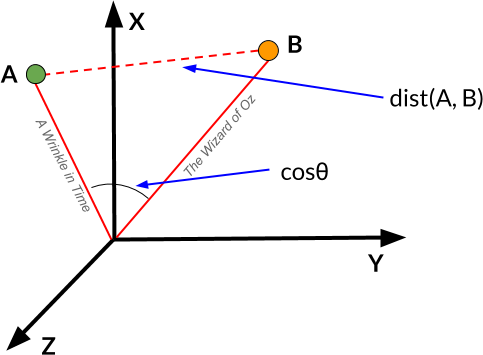 

Однако возникает вопрос: как быстрее всего найти среди 10 000 книг наиболее похожую? Не перебирать же их все! На помощь приходит **метод ближайших соседей** (*approximate k-nn*), который реализован в библиотеке [NMSLIB](https://github.com/nmslib/nmslib).

**Non-Metric Space Library (NMSLIB)** — это эффективная кроссплатформенная библиотека поиска сходства и инструментарий для оценки методов поиска сходства. Основная библиотека не имеет никаких сторонних зависимостей. В последнее время она набирает популярность: например, она стала частью сервиса [Amazon Elasticsearch](https://aws.amazon.com/about-aws/whats-new/2020/03/build-k-nearest-neighbor-similarity-search-engine-with-amazon-elasticsearch-service/). Подробнее о библиотеке вы можете узнать [здесь](https://github.com/nmslib/nmslib).

В основе метода лежит идея о том, что вместо того чтобы перебирать все векторы, мы можем очень быстро обходить граф, каждая вершина которого соответсвует эмбеддингу книги.

> **Примечание.** Мы не будем сейчас затрагивать процесс построения этого графа, который реализуется в библиотеке, вынеся эти тонкости в часть образовательной программы трека «*ML-инженер*». С кратким описанием алгоритма построения и обхода графа вы можете познакомиться в [этой статье](https://habr.com/ru/company/vk/blog/338360/). Для любознательных — со всеми математическими выкладками библиотеки *NMSLIB* можно познакомиться в [оригинальной статье](https://arxiv.org/pdf/1508.05470.pdf).

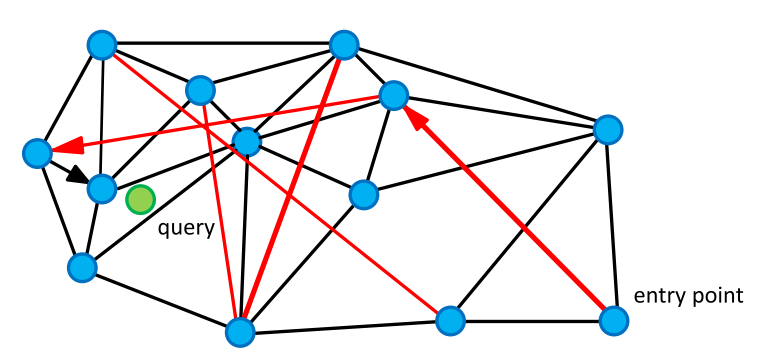 

In [ ]:
#!pip install nmslib

После установки импортируем её и выполним необходимые преобразования:

* Инициализируем граф для поиска. В терминах библиотеки это называется **NMSLIB-индекс**. Для инициализации этого объекта используется функция [init()](https://nmslib.github.io/nmslib/api.html#nmslib-init). Дальнейшие методы вызываются от имени этого объекта.

> **Примечание.** Методика похожа на работу с *DataFrame*: сначала мы создаём объект класса *DataFrame*, а затем работаем с ним при помощи методов.

* Добавим на этот граф вершины — наши эмбеддинги. Для этого используем метод [addDataPointBatch()](https://nmslib.github.io/nmslib/api.html#nmslib.dist.FloatIndex.addDataPointBatch).

* Создадим индекс и сделаем его доступным для поиска. Для этого используется метод [createIndex()](https://nmslib.github.io/nmslib/api.html#nmslib.dist.FloatIndex.createIndex).

In [28]:
import nmslib

In [29]:
#Инициализируем наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши книги в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


Теперь давайте напишем вспомогательную функцию для поиска с помощью *nmslib*. Для этого используется метод [knnQuery()](https://nmslib.github.io/nmslib/api.html#nmslib.dist.FloatIndex.createIndex): он позволяет найти *K* ближайших соседей вектора в индексе (в графе). Для его вызова необходимо указать следующие параметры:

`knnQuery(vector: object, k: int=10)`

* `vector` — вектор признаков (эмбеддинг), по которому нужно искать похожие книги;
* `k` — количество искомых ближайших соседей (мы возьмём десять).

Метод возвращает кортеж из двух массивов:

* `ids` — массив из идентификаторов ближайших соседей;
* `distances` — массив, элементами которого являются вычисленные расстояния от соседей до заданного вектора.

In [30]:
#Вспомогательная функция для поиска по графу
def nearest_books_nms(book_id, index, n=10):
    nn = index.knnQuery(item_embeddings[book_id], k=n)
    return nn

### **АНАЛИЗ РЕКОМЕНДАЦИЙ ПОСТРОЕННОЙ МОДЕЛИ**

Теперь, когда у нас есть функция для поиска десяти наиболее похожих книг, давайте попробуем написать рекомендации к какой-нибудь книге, например к роману «1984» Джорджа Оруэлла. Для этого воспользуемся частичным поиском по неполным совпадениям в столбце *title*. Уберём чувствительность к регистру, приведя оригинальные названия к нижнему регистру.

In [31]:
#Отфильтруем только те, где в названии встречается подстрока "1984"
books[books['title'].apply(lambda x: x.lower().find('1984')) >= 0]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
12,13,5470,5470,153313,995,451524934,9.780452e+12,"George Orwell, Erich Fromm, Celâl Üster",1949.0,Nineteen Eighty-Four,...,1956832,2053394,45518,41845,86425,324874,692021,908229,https://images.gr-assets.com/books/1348990566m...,https://images.gr-assets.com/books/1348990566s...
845,846,5472,5472,2966408,51,151010269,9.780151e+12,"George Orwell, Christopher Hitchens",1950.0,Animal Farm & 1984,...,116197,118761,1293,1212,3276,16511,40583,57179,https://images.gr-assets.com/books/1327959366m...,https://images.gr-assets.com/books/1327959366s...
9795,9796,201145,201145,2563528,25,64440508,9.780064e+12,"Else Holmelund Minarik, Maurice Sendak",1968.0,A Kiss for Little Bear,...,11063,11604,126,87,284,1898,3053,6282,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


Видим, что у нас есть три совпадения, где в названиях встречается "1984".

Давайте возьмём книгу с `book_id` 846. Это книга, в которую включены повесть «Скотный двор» ("*Animal Farm*") и роман-антиутопия «1984».

Найдём похожие книги — для этого воспользуемся написанной ранее функцией:

In [32]:
#Вызываем функцию для поиска ближайших соседей
print(nearest_books_nms(846, nms_idx))

(array([ 846,   14,   55,   13,  809,   48,  529, 8140,  271,   28],
      dtype=int32), array([0.        , 0.03879946, 0.04731965, 0.06963301, 0.07667887,
       0.08105701, 0.08562124, 0.09757084, 0.106058  , 0.10751975],
      dtype=float32))


Как мы говорили ранее, наша функция возвращает кортеж из двух массивов: *numpy*-вектор идентификаторов и *numpy*-вектор мер схожести (расстояний) между заданной книгой и её ближайшими соседями.

Пока что нас интересуют только идентификаторы— выделим их в отдельную переменную:

In [33]:
#Выделяем идентификаторы рекомендованных книг
nbm = nearest_books_nms(846, nms_idx)[0]
nbm

array([ 846,   14,   55,   13,  809,   48,  529, 8140,  271,   28],
      dtype=int32)

> **Примечание**. Обратите внимание, что ближайшей к заданной книге всегда будет она сама, поэтому идентификатор этой книги всегда будет первым в списке рекомендаций. Пока что мы закроем на это глаза, однако в дальнейшем при разработке прототипа приложения мы исправим этот момент.

Посмотрим на рекомендованные нам книги. Найдём идентификаторы книг, которые находятся в списке `nbm`:

In [34]:
#Посмотрим на авторов и названия рекомендованных книг
books[books.book_id.isin(nbm)][['authors', 'title']]

,authors,title
12,"George Orwell, Erich Fromm, Celâl Üster",1984
13,George Orwell,Animal Farm
27,William Golding,Lord of the Flies
47,Ray Bradbury,Fahrenheit 451
54,Aldous Huxley,Brave New World
270,Daniel Keyes,Flowers for Algernon
528,"Jonathan Swift, Robert DeMaria Jr.",Gulliver's Travels
808,"Aldous Huxley, Christopher Hitchens",Brave New World / Brave New World Revisited
845,"George Orwell, Christopher Hitchens",Animal Farm / 1984
8139,Aldous Huxley,Brave New World Revisited


Как можно увидеть, в результатах есть действительно похожие книги. Первыми идут отдельные книги — «1984» и «Скотный двор» ("*Animal Farm*"). Далее следуют «451 градус по Фаренгейту» Рэя Брэдбери ("*Fahrenheit 451*") и «О дивный новый мир» Олдоса Хаксли ("*Brave New World*"), которые также являются антиутопиями.

Не забудьте сохранить полученные эмбеддинги — они пригодятся в дальнейшем при реализации прототипа:

In [35]:
with open('item_embeddings.pkl', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

Итак, за пару десятков строк кода мы написали свою рекомендательную систему. Отлично! Следующим этапом будет создание визуального прототипа для нашей модели.